In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
''' Merge csv files '''

test_dir = 'tests/test2'

dlist = []
dirs = [d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir,d))]
for d in dirs:
	d = os.path.abspath(test_dir+'/'+d)
	dlist += [os.path.join(d,file) for file in os.listdir(d) if file.endswith(".csv")]

In [3]:
filename = 'results2.csv'

In [4]:
df = pd.read_csv(dlist[0], skipinitialspace=True)
for x in range(1,len(dlist)):
    df = df.append(pd.read_csv(dlist[x], skipinitialspace=True))
df.to_csv(filename,index=False)

In [5]:
def autolabel(rects):
	for rect in rects:
		height = rect.get_height()
		ax.annotate('{}'.format(height),
					xy=(rect.get_x() + rect.get_width() / 2, height),
					xytext=(0, 3),  # 3 points vertical offset
					textcoords="offset points",
					ha='center', va='bottom')

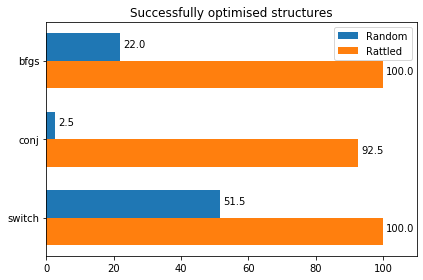

In [6]:
''' No. of optimised structures per method (diff no. of total structures) '''
''' Normalised to per cent '''

ran_succ_list = []
rat_succ_list = []
totals = {}


df = pd.read_csv(filename, skipinitialspace=True)
labels = list(df['method'].unique())
dicts = {}

for method in labels:
	random = df[df['structure'].str.contains(
		"rat") == False].loc[df['method'] == method]
	rattled = df[df['structure'].str.contains(
		"rat")].loc[df['method'] == method]

	ran_succ = len([b for b in random['opt_succ'] if b])
	rat_succ = len([b for b in rattled['opt_succ'] if b])

	ran_perc = 0
	if len(random):
		ran_perc = ran_succ*100/len(random)
	rat_perc = 0
	if len(rattled):
		rat_perc = rat_succ*100/len(rattled)

	ran_succ_list.append(ran_perc)
	rat_succ_list.append(rat_perc)

''' Plot '''
    
y = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.barh(y - width/2, ran_succ_list, width, label='Random') # x% per init category
rects2 = ax.barh(y + width/2, rat_succ_list, width, label='Rattled')

# Add some text for labels, title and custom x-axis tick labels, etc.
for i, v in enumerate(ran_succ_list):
	ax.text(v + 1, i - width/2, str(v))

for i, v in enumerate(rat_succ_list):
	ax.text(v + 1, i + width/2, str(v))

ax.set_title('Successfully optimised structures')
ax.set_xlim(0,110)
ax.set_yticks(y)
ax.set_yticklabels(labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.legend()

fig.tight_layout()

plt.savefig('OptSucc.pdf', format='pdf')
plt.show()

In [14]:
''' Find stdev map files '''

test_dir = 'tests/test2'

map_list = []
for d in dirs:
	d = os.path.abspath(test_dir+'/'+d)
	map_list += [os.path.join(d,file) for file in os.listdir(d) if file == 'map_files.txt']

In [15]:
''' Make a stdev column '''
df = pd.read_csv(filename, skipinitialspace=True)
df['stdev'] = pd.Series(np.zeros(len(df['structure'])), index=df.index)

In [16]:
for file in map_list:
    method = file.split('/')[-2]
    for line in open(file,'r'):
        if 'rat_structure' in line:
            stdev = float(line.split(':')[-2].split('/')[-2][3:])
            struct = line.split(':')[-1].lstrip(' ').rstrip('\n')
            mask = (df['method'] == method) & (df['structure'] == struct)
            df.loc[mask,'stdev'] = stdev

,structure,method,energy,gnorm,opt_time,peak_mem,cpu_time,opt_succ,cycles,hessian,failure,options,switch,stdev
0,structure1,bfgs,-469.480836,6.745890e-03,0.9738,0.60,0.9738,False,102,24,**** Conditions for a minimum have not been ...,time 12\n,-1,0.0
1,structure2,bfgs,-422.890010,4.560240e+00,0.5928,0.60,0.5928,False,39,40,**** Conditions for a minimum have not been ...,time 12\n,-1,0.0
2,structure3,bfgs,inf,0.000000e+00,20.9326,17.04,20.9326,False,5,5,**** CPU limit has been exceeded - restart o...,time 12\n,-1,0.0
3,structure4,bfgs,inf,8.539431e+06,0.2329,0.60,0.2329,False,17,18,**** Conditions for a minimum have not been ...,time 12\n,-1,0.0
4,structure5,bfgs,inf,0.000000e+00,0.0000,0.00,0.0000,False,6,7,**** Too many reciprocal lattice vectors nee...,time 12\n,-1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,rat_structure396,switch,-475.567318,7.720000e-06,0.0913,0.60,0.0914,True,21,1,NaN,switch_minimiser bfgs gnorm 0.1\n,17,0.1
1196,rat_structure397,switch,-475.567318,2.211000e-05,0.0962,0.60,0.0962,True,22,1,NaN,switch_minimiser bfgs gnorm 0.1\n,18,0.1
1197,rat_structure398,switch,-475.567318,6.621000e-05,0.0868,0.60,0.0868,True,20,1,NaN,switch_minimiser bfgs gnorm 0.1\n,18,0.1
1198,rat_structure399,switch,-475.567318,4.267000e-05,0.1128,0.60,0.1128,True,26,1,NaN,switch_minimiser bfgs gnorm 0.1\n,21,0.1


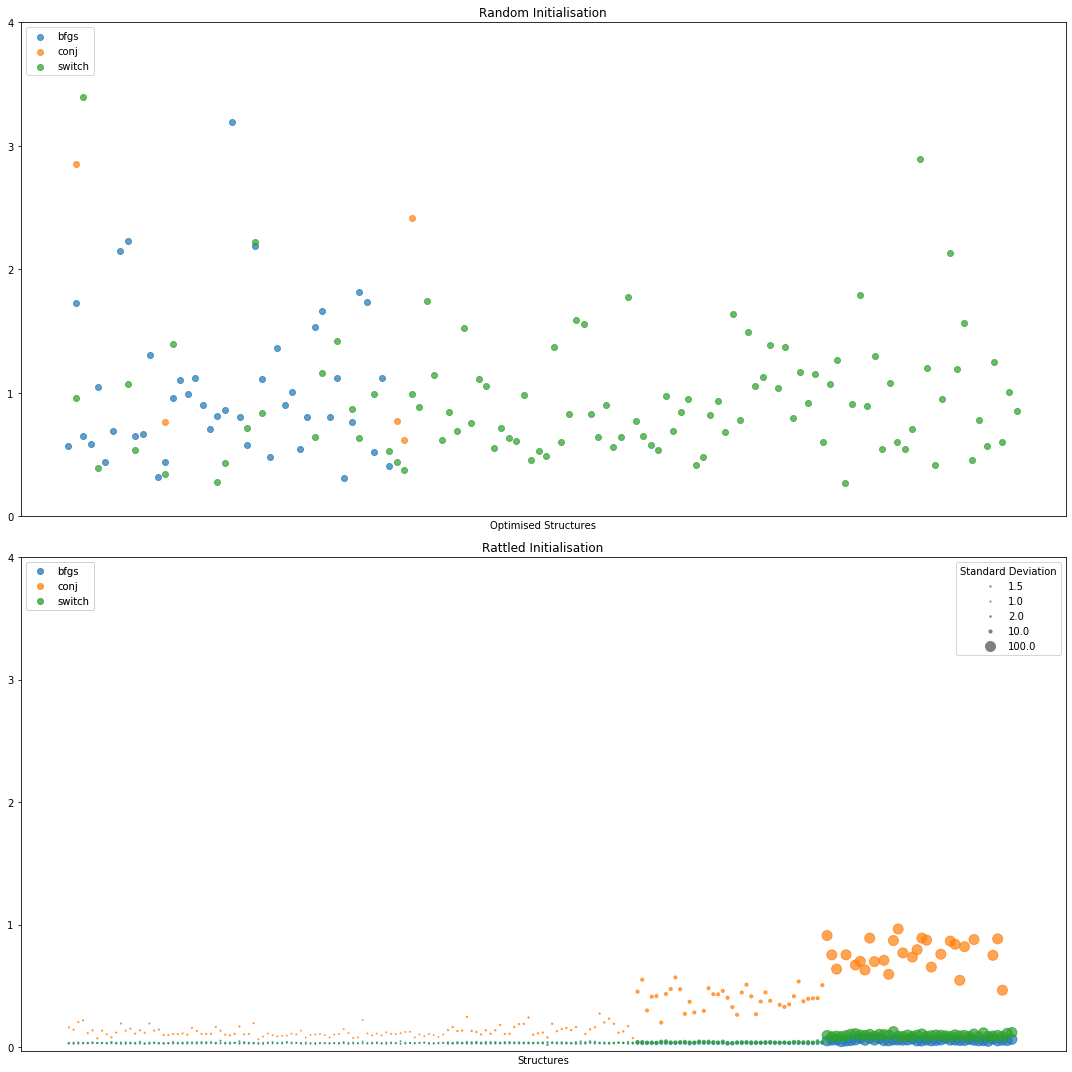

In [192]:
''' Optimisation time per method (diff no. of total structures) '''

FONTSIZE = 12

methods = list(df['method'].unique())
maps = list(df['method'])
ran_succ = df[df['structure'].str.contains(
		"rat") == False].loc[df['opt_succ'] == True] # find successful optimisations
rat_succ = df[df['structure'].str.contains(
		"rat") == True].loc[df['opt_succ'] == True] 

fig, axs = plt.subplots(2,figsize=(15,15))
colors = {'blue' : methods[0], 'orange' : methods[1], 'green' : methods[2]}
clabels = ['blue', 'orange', 'green']

''' Random '''

for color in clabels:
    x = ran_succ.loc[df['method'] == colors[color]]['structure']
    y = ran_succ.loc[df['method'] == colors[color]]['opt_time']
    axs[0].scatter(x, y, c='tab:'+color, label=colors[color],
               alpha=0.7)

''' Rattled '''    

slabels = []
for color in clabels:
    x = rat_succ.loc[df['method'] == colors[color]]['structure']
    y = rat_succ.loc[df['method'] == colors[color]]['opt_time']
    sizes = rat_succ.loc[df['method'] == colors[color]]['stdev'] * 1000
    slabels += [s for s in sizes.unique() if s not in slabels]
    scatter = axs[1].scatter(x, y, s=sizes, c='tab:'+color,
                            alpha=0.7)

start0, end0 = axs[0].get_ylim()
start1, end1 = axs[1].get_ylim()    

end = max(end0, end1)+1

axs[0].legend(loc="upper left")
axs[0].set_xticks([])
axs[0].set_xlabel('Optimised Structures')
axs[0].yaxis.set_ticks(np.arange(0, end))
axs[0].set_title('Random Initialisation', fontsize=FONTSIZE)

h = [plt.scatter([],[], s=i, c="gray") for i in slabels]
leg = plt.legend(handles=h, labels=slabels,loc="upper right", title="Standard Deviation")
axs[1].add_artist(leg)

h = [plt.plot([],[], color='tab:'+c, alpha=0.7, marker="o", ls="")[0] for c in colors]
leg = plt.legend(handles=h, labels=[colors[c] for c in colors],loc="upper left")
axs[1].add_artist(leg)

axs[1].set_xlabel('Structures')
axs[1].yaxis.set_ticks(np.arange(0, end))
axs[1].set_title('Rattled Initialisation', fontsize=FONTSIZE)
axs[1].set_xticks([])

fig.tight_layout()

plt.savefig('OptTime.pdf', format='pdf')
plt.show()